Loading data

In [ ]:
## Loading data

import h5py

filepath = "/content/drive/MyDrive/SubsurfaceFields/Data/ARGO_GoM_20220920.mat"

# Load the parameters of interest
with h5py.File(filepath, 'r') as f:
    keys = list(f.keys())
    print(keys)
    adt = f['ADT_loc'][:]
    lat = f['LAT'][:]
    lon = f['LON'][:]
    pres = f['PRES'][:]
    rho = f['RHO'][:]
    sal = f['SAL'][:]
    sh1950 = f['SH1950'][:]
    temp = f['TEMP'][:]
    time = f['TIME'][:]
    print(lat.shape, lon.shape, pres.shape, rho.shape, sal.shape, sh1950.shape, temp.shape, time.shape)



['ADT_loc', 'ADTnoseason_loc', 'LAT', 'LON', 'PRES', 'RHO', 'SAL', 'SH1950', 'SIG', 'SPICE', 'TEMP', 'TIME']
(4890, 1) (4890, 1) (4890, 2001) (4890, 2001) (4890, 2001) (4890, 1) (4890, 2001) (4890, 1)


Making figure 2 from Meunier et al  2022

               LAT          LON          ADT       SH1950           TIME
count  4890.000000  4890.000000  4890.000000  4890.000000    4890.000000
mean     25.083003   -89.618622    45.885235    45.885235  737679.098947
std       1.743978     3.544237    23.300758    23.921218     788.017776
min      19.234307   -96.799805    -5.130000    -1.204781  735461.229919
25%      24.158205   -92.620074    29.862500    28.580138  737618.767639
50%      25.244370   -89.202920    39.650000    39.103768  737900.160411
75%      26.173983   -86.712215    56.049167    57.605282  738194.595425
max      28.808650   -82.665100   127.523333   129.933124  738777.488715


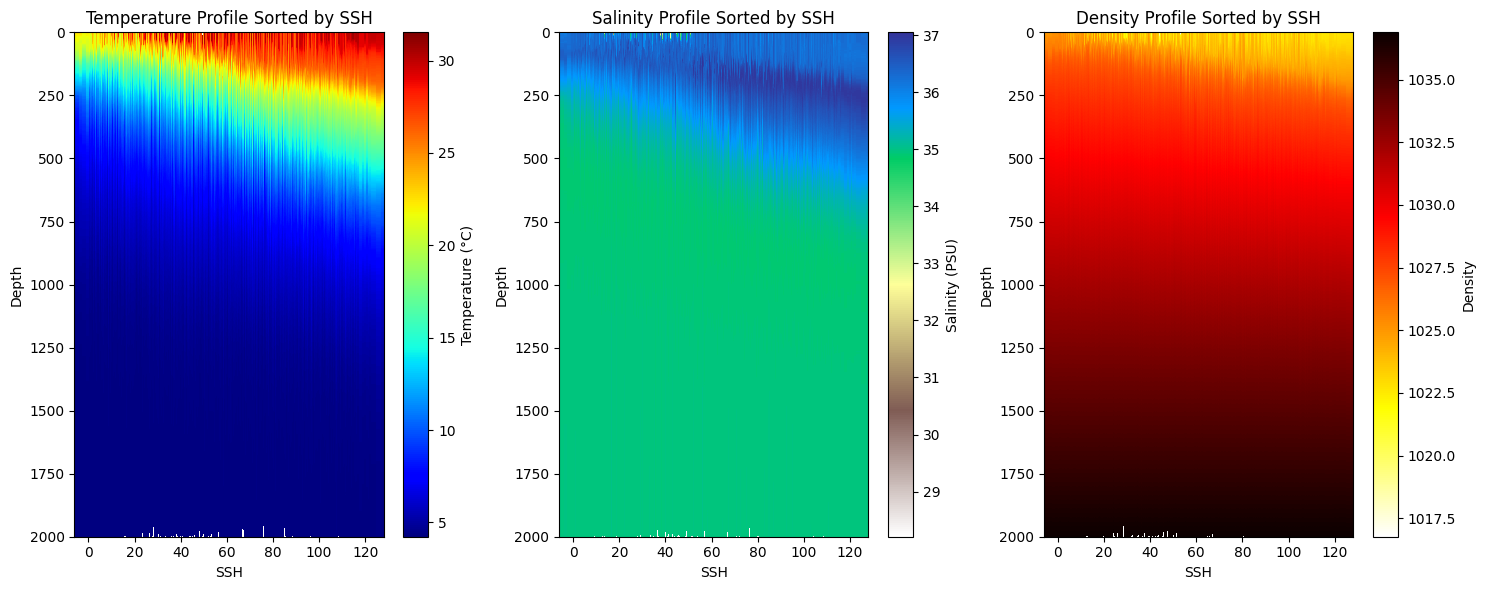

In [ ]:
import pandas as pd
import numpy as np

# Convert the data to Pandas Series for easy statistics
lat_series = pd.Series(np.squeeze(lat))
lon_series = pd.Series(np.squeeze(lon))
adt_series = pd.Series(np.squeeze(adt))
sh1950_series = pd.Series(np.squeeze(sh1950))
time_series = pd.Series(np.squeeze(time))

# Compute basic statistics
summary_df = pd.DataFrame({
    'LAT': lat_series.describe(),
    'LON': lon_series.describe(),
    'ADT': adt_series.describe(),
    'SH1950': sh1950_series.describe(),
    'TIME': time_series.describe()
})

print(summary_df)

import matplotlib.pyplot as plt

# Convert to numpy arrays for easier manipulation
lat = np.squeeze(lat)
lon = np.squeeze(lon)
pres = np.squeeze(pres)
rho = np.squeeze(rho)
sal = np.squeeze(sal)
adt = np.squeeze(adt)
sh1950 = np.squeeze(sh1950)
temp = np.squeeze(temp)
time = np.squeeze(time)

# Sort the data by SH1950
sort_indices = np.argsort(adt)
adt_sorted = adt[sort_indices]
temp_sorted = temp[sort_indices, :]
pres_sorted = pres[sort_indices, :]
sal_sorted = sal[sort_indices, :]
rho_sorted = rho[sort_indices, :]

# Plot the temperature-depth profile
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

# Plot temperature
im1 = axs[0].pcolormesh(adt_sorted, pres_sorted[0,:], temp_sorted.T, cmap='jet')
axs[0].invert_yaxis()
plt.colorbar(im1, ax=axs[0], label='Temperature (°C)')
temp_scale = im1.get_clim()
axs[0].set_title('Temperature Profile Sorted by SSH')
axs[0].set_xlabel('SSH')
axs[0].set_ylabel('Depth')

# Plot salinity with a different colormap
im2 = axs[1].pcolormesh(adt_sorted, pres_sorted[0,:], sal_sorted.T, cmap='terrain_r')
axs[1].invert_yaxis()
plt.colorbar(im2, ax=axs[1], label='Salinity (PSU)')
sal_scale = im2.get_clim()
axs[1].set_title('Salinity Profile Sorted by SSH')
axs[1].set_xlabel('SSH')
axs[1].set_ylabel('Depth')

# Plot density with a different colormap
im3 = axs[2].pcolormesh(adt_sorted, pres_sorted[0,:], rho_sorted.T, cmap='hot')
axs[2].invert_yaxis()
plt.colorbar(im3, ax=axs[2], label='Density')
axs[2].set_title('Density Profile Sorted by SSH')
axs[2].set_xlabel('SSH')
axs[2].set_ylabel('Depth')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

1st Attempt at GEM. This uses the entire data. Next step will be to do this for each month

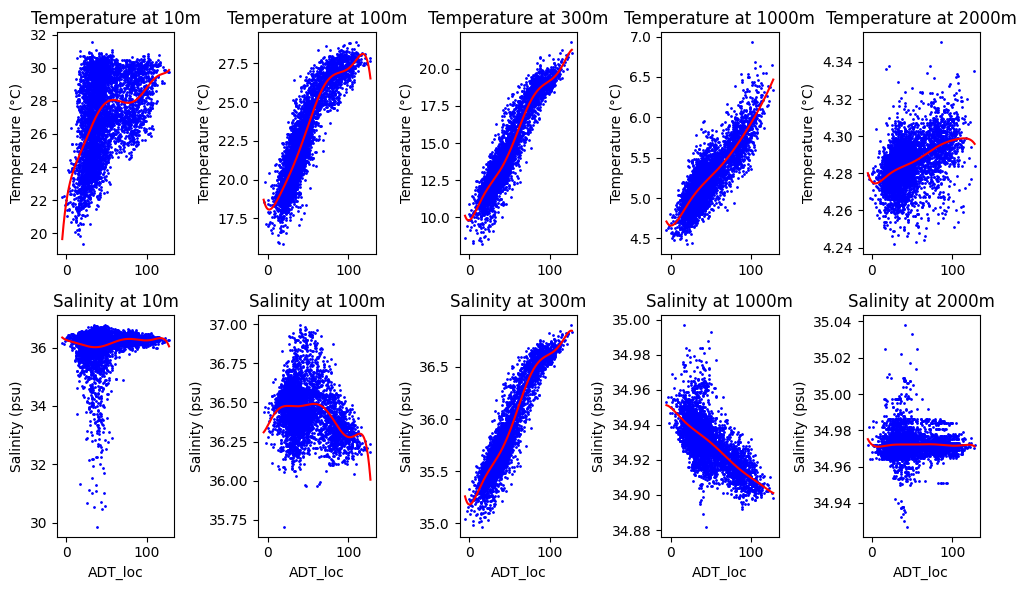

In [ ]:
degree = 7 # 7 seems to yield the best results so far

# Define the pressure grid (as in Meunier 2022)
pressure_grid = np.arange(1, 2000)

# Define the depths for which to make plots
depths = [10, 100, 300, 1000, 2000]

# Add a small value multiplied by the index to the sorted ADT_loc values to ensure they are strictly increasing
adt_sorted_increasing = adt_sorted + np.arange(len(adt_sorted)) * 1e-10

from scipy.interpolate import PchipInterpolator, interp1d
from numpy.polynomial.polynomial import Polynomial

# Initialize lists to store the polynomial fits
TEMP_polyfits = []
SAL_polyfits = []

# For each pressure level
for i in range(len(pressure_grid)):

    # Get the temperature and salinity at this pressure level
    TEMP_at_p = temp_sorted[:, i]
    SAL_at_p = sal_sorted[:, i]

    # Handle NaNs by interpolating
    valid_indices_TEMP = ~np.isnan(TEMP_at_p)
    valid_indices_SAL = ~np.isnan(SAL_at_p)

    if np.sum(valid_indices_TEMP) > 1:  # Need at least two points to interpolate
        interp_TEMP = interp1d(adt_sorted_increasing[valid_indices_TEMP], TEMP_at_p[valid_indices_TEMP], fill_value="extrapolate")
        TEMP_at_p = interp_TEMP(adt_sorted_increasing)

    if np.sum(valid_indices_SAL) > 1:  # Need at least two points to interpolate
        interp_SAL = interp1d(adt_sorted_increasing[valid_indices_SAL], SAL_at_p[valid_indices_SAL], fill_value="extrapolate")
        SAL_at_p = interp_SAL(adt_sorted_increasing)

    # Skip polynomial fit for pressure levels with no valid values after handling NaNs
    if not np.all(np.isnan(TEMP_at_p)) and not np.all(np.isnan(SAL_at_p)):
        # Fit a polynomial of the specified degree to the temperature and salinity at this pressure level
        TEMP_polyfit = Polynomial.fit(adt_sorted_increasing, TEMP_at_p, degree)
        SAL_polyfit = Polynomial.fit(adt_sorted_increasing, SAL_at_p, degree)

        # Append the polynomial fit to the lists
        TEMP_polyfits.append(TEMP_polyfit)
        SAL_polyfits.append(SAL_polyfit)

# Create a dictionary to store the polynomial fits
polyfits = {"TEMP": TEMP_polyfits, "SAL": SAL_polyfits}

# Initialize the figure
fig, axs = plt.subplots(2, len(depths), figsize=(10, 6))

# For each depth
for i, depth in enumerate(depths):

    # Calculate the pressure grid index closest to the depth
    idx = np.abs(pressure_grid - depth).argmin()-1

    # Plot the raw temperature and salinity values at this depth
    axs[0, i].scatter(adt_sorted, temp_sorted[:, idx], s=1, color='blue')
    axs[1, i].scatter(adt_sorted, sal_sorted[:, idx], s=1, color='blue')

    # Generate a range of ADT_loc values for the interpolated data
    ADT_loc_range = np.linspace(adt_sorted.min(), adt_sorted.max(), 1000)

    # Plot the polynomial fits for temperature and salinity at this depth
    axs[0, i].plot(ADT_loc_range, polyfits['TEMP'][idx](ADT_loc_range), color='red')
    axs[1, i].plot(ADT_loc_range, polyfits['SAL'][idx](ADT_loc_range), color='red')

    # Set the titles and labels
    axs[0, i].set_title(f"Temperature at {depth}m")
    # axs[0, i].set_xlabel('ADT_loc')
    axs[0, i].set_ylabel('Temperature (°C)')
    axs[1, i].set_title(f"Salinity at {depth}m")
    axs[1, i].set_xlabel('ADT_loc')
    axs[1, i].set_ylabel('Salinity (psu)')

# Adjust the layout and show the plots
plt.tight_layout()
plt.show()


Generating synthetic field from GEM

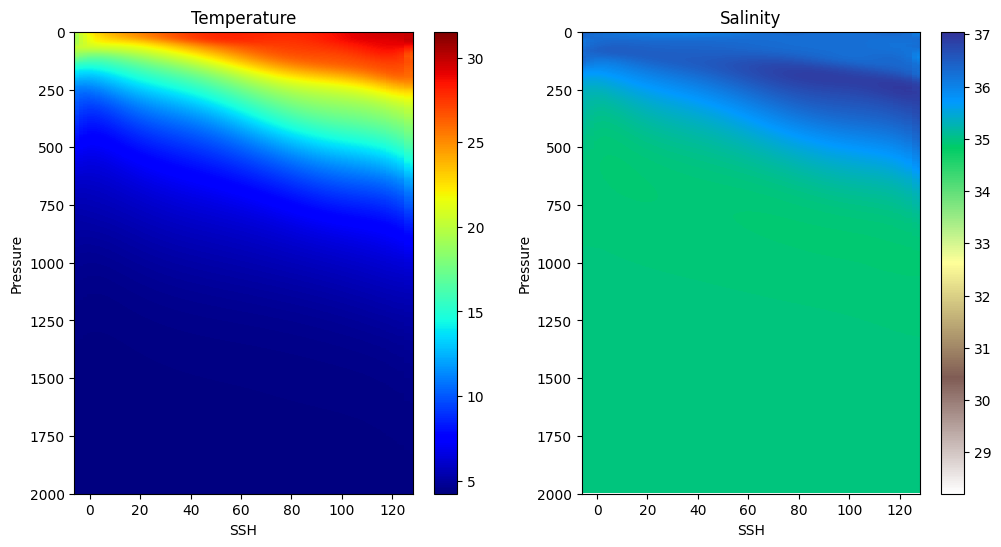

In [ ]:
# Define the grid points where we want to interpolate the data
grid_points = np.array([adt_sorted.repeat(pres_sorted.shape[1]), pres_sorted.flatten()]).T

# Interpolate the temperature and salinity data onto the new grid
temp_interpolated = np.empty(temp_sorted.shape)
sal_interpolated = np.empty(sal_sorted.shape)

# For each pressure level
for i in range(len(polyfits['TEMP'])):
    # Evaluate the fitted polynomial at the given SSH values
    temp_interpolated[:, i] = polyfits['TEMP'][i](adt_sorted)
    sal_interpolated[:, i] = polyfits['SAL'][i](adt_sorted)

temp_interpolated, sal_interpolated

# # Define the pressure levels for which polynomial fits were performed
# pressure_levels_with_fits = pressure_grid[:len(polyfits['TEMP'])]

# Now create 2D boundary arrays for the pressure levels and SSH values.
pres_grid_2D, ssh_values_2D = np.meshgrid(pres[0,:], adt_sorted, indexing='ij')

# Create plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Temperature plot
c1 = axs[0].pcolormesh(ssh_values_2D, pres_grid_2D, temp_interpolated.T, cmap='jet')
axs[0].invert_yaxis()  # Invert the y-axis to show the surface at the top
fig.colorbar(c1, ax=axs[0])
c1.set_clim(temp_scale)
axs[0].set_xlabel('SSH')
axs[0].set_ylabel('Pressure')
axs[0].set_title('Temperature')

# Salinity plot
c2 = axs[1].pcolormesh(ssh_values_2D, pres_grid_2D, sal_interpolated.T, cmap='terrain_r')
axs[1].invert_yaxis()  # Invert the y-axis to show the surface at the top
fig.colorbar(c2, ax=axs[1])
c2.set_clim(sal_scale)
axs[1].set_xlabel('SSH')
axs[1].set_ylabel('Pressure')
axs[1].set_title('Salinity')



plt.show()


We want to see the residuals, so let's interpolate the original data to compare

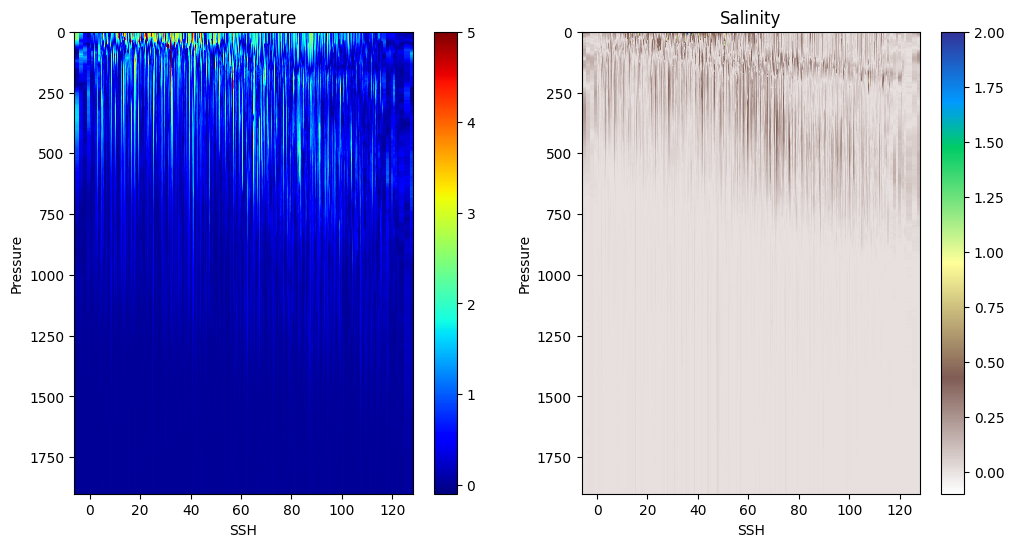

In [ ]:
# Create plots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

sqdiff_T = (temp_interpolated.T - temp_sorted.T) **2
sqdiff_S = (sal_interpolated.T - sal_sorted.T) **2

rms_T = np.sqrt(sqdiff_T)
rms_S = np.sqrt(sqdiff_S)

# Temperature plot
c1 = axs[0].pcolormesh(ssh_values_2D, pres_grid_2D, rms_T, cmap='jet')
axs[0].invert_yaxis()  # Invert the y-axis to show the surface at the top
fig.colorbar(c1, ax=axs[0])
c1.set_clim(5,0)
axs[0].set_xlabel('SSH')
axs[0].set_ylabel('Pressure')
axs[0].set_title('Temperature')
axs[0].set_ylim(1900,0)

# Salinity plot
c2 = axs[1].pcolormesh(ssh_values_2D, pres_grid_2D, rms_S, cmap='terrain_r')
axs[1].invert_yaxis()  # Invert the y-axis to show the surface at the top
fig.colorbar(c2, ax=axs[1])
c2.set_clim(2,0)
axs[1].set_xlabel('SSH')
axs[1].set_ylabel('Pressure')
axs[1].set_title('Salinity')
axs[1].set_ylim(1900,0)

plt.show()

They did RMS in the paper, so we need the monthly fields to do so...